In [1]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import *
spark = SparkSession.builder.appName('logistic_regression_adv').getOrCreate()
from pyspark.ml.classification import LogisticRegression
import pandas as pd
from pyspark.ml.feature import (VectorAssembler,VectorIndexer,
                                OneHotEncoder,StringIndexer)

In [2]:
dataset = pd.read_csv("dataset.csv")

Explore Data

In [3]:
df = spark.read.csv('dataset.csv', inferSchema=True, header=True)
df.printSchema()

root
 |-- accident_index: string (nullable = true)
 |-- vehicle_reference: integer (nullable = true)
 |-- vehicle_type: integer (nullable = true)
 |-- towing_and_articulation: integer (nullable = true)
 |-- vehicle_manoeuvre: integer (nullable = true)
 |-- vehicle_location-restricted_lane: integer (nullable = true)
 |-- junction_location: integer (nullable = true)
 |-- skidding_and_overturning: integer (nullable = true)
 |-- hit_object_in_carriageway: integer (nullable = true)
 |-- vehicle_leaving_carriageway: integer (nullable = true)
 |-- hit_object_off_carriageway: integer (nullable = true)
 |-- 1st_point_of_impact: integer (nullable = true)
 |-- was_vehicle_left_hand_drive?: integer (nullable = true)
 |-- journey_purpose_of_driver: integer (nullable = true)
 |-- sex_of_driver: integer (nullable = true)
 |-- age_of_driver: integer (nullable = true)
 |-- age_band_of_driver: integer (nullable = true)
 |-- engine_capacity_(cc): integer (nullable = true)
 |-- propulsion_code: integer (n

In [4]:
print(dataset.shape)

(14999, 70)


In [5]:
df.columns

['accident_index',
 'vehicle_reference',
 'vehicle_type',
 'towing_and_articulation',
 'vehicle_manoeuvre',
 'vehicle_location-restricted_lane',
 'junction_location',
 'skidding_and_overturning',
 'hit_object_in_carriageway',
 'vehicle_leaving_carriageway',
 'hit_object_off_carriageway',
 '1st_point_of_impact',
 'was_vehicle_left_hand_drive?',
 'journey_purpose_of_driver',
 'sex_of_driver',
 'age_of_driver',
 'age_band_of_driver',
 'engine_capacity_(cc)',
 'propulsion_code',
 'age_of_vehicle',
 'driver_imd_decile',
 'driver_home_area_type',
 'vehicle_imd_decile',
 'NUmber_of_Casualities_unique_to_accident_index',
 'No_of_Vehicles_involved_unique_to_accident_index',
 'location_easting_osgr',
 'location_northing_osgr',
 'longitude',
 'latitude',
 'police_force',
 'accident_severity',
 'number_of_vehicles',
 'number_of_casualties',
 'date',
 'day_of_week',
 'time',
 'local_authority_(district)',
 'local_authority_(highway)',
 '1st_road_class',
 '1st_road_number',
 'road_type',
 'speed_lim

In [6]:
dataset.head(n=5)

,accident_index,vehicle_reference,vehicle_type,towing_and_articulation,vehicle_manoeuvre,vehicle_location-restricted_lane,junction_location,skidding_and_overturning,hit_object_in_carriageway,vehicle_leaving_carriageway,...,age_band_of_casualty,casualty_severity,pedestrian_location,pedestrian_movement,car_passenger,bus_or_coach_passenger,pedestrian_road_maintenance_worker,casualty_type,casualty_home_area_type,casualty_imd_decile
0,201506E098757,2.0,9.0,0.0,18.0,0.0,8.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,201506E098766,1.0,9.0,0.0,9.0,0.0,8.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,201506E098766,2.0,9.0,0.0,18.0,0.0,8.0,0.0,0.0,0.0,...,8.0,3.0,0.0,0.0,0.0,0.0,0.0,9.0,1.0,3.0
3,201506E098777,1.0,20.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,6.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
4,201506E098780,1.0,9.0,0.0,15.0,0.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
dataset.head(1)

,accident_index,vehicle_reference,vehicle_type,towing_and_articulation,vehicle_manoeuvre,vehicle_location-restricted_lane,junction_location,skidding_and_overturning,hit_object_in_carriageway,vehicle_leaving_carriageway,...,age_band_of_casualty,casualty_severity,pedestrian_location,pedestrian_movement,car_passenger,bus_or_coach_passenger,pedestrian_road_maintenance_worker,casualty_type,casualty_home_area_type,casualty_imd_decile
0,201506E098757,2.0,9.0,0.0,18.0,0.0,8.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
dataset.tail(n=5)

,accident_index,vehicle_reference,vehicle_type,towing_and_articulation,vehicle_manoeuvre,vehicle_location-restricted_lane,junction_location,skidding_and_overturning,hit_object_in_carriageway,vehicle_leaving_carriageway,...,age_band_of_casualty,casualty_severity,pedestrian_location,pedestrian_movement,car_passenger,bus_or_coach_passenger,pedestrian_road_maintenance_worker,casualty_type,casualty_home_area_type,casualty_imd_decile
14994,201501HT20988,1.0,5.0,0.0,18.0,0.0,2.0,0.0,0.0,0.0,...,4.0,3.0,5.0,4.0,0.0,0.0,2.0,0.0,-1.0,-1.0
14995,201501HT20990,1.0,4.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,...,7.0,3.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,6.0
14996,201501HT20990,2.0,9.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14997,201501HT20991,1.0,9.0,0.0,18.0,9.0,1.0,0.0,10.0,1.0,...,5.0,3.0,6.0,9.0,0.0,0.0,2.0,0.0,1.0,2.0
14998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
dataset.tail(1)

,accident_index,vehicle_reference,vehicle_type,towing_and_articulation,vehicle_manoeuvre,vehicle_location-restricted_lane,junction_location,skidding_and_overturning,hit_object_in_carriageway,vehicle_leaving_carriageway,...,age_band_of_casualty,casualty_severity,pedestrian_location,pedestrian_movement,car_passenger,bus_or_coach_passenger,pedestrian_road_maintenance_worker,casualty_type,casualty_home_area_type,casualty_imd_decile
14998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Bar Chart Visualization

In [10]:
dataset['accident_severity'].value_counts().plot.bar()

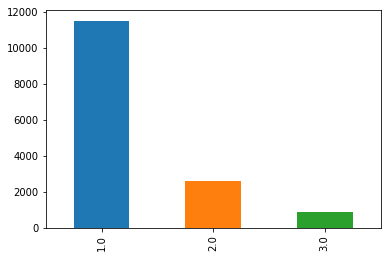

In [11]:
dataset['sex_of_driver'].value_counts().plot.bar()

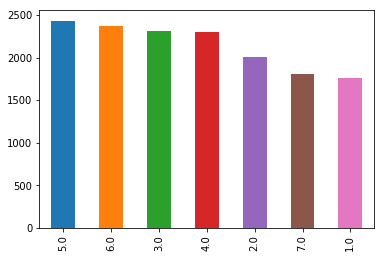

In [12]:
dataset['day_of_week'].value_counts().plot.bar()

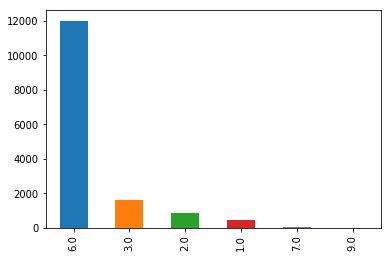

In [13]:
dataset['road_type'].value_counts().plot.bar()

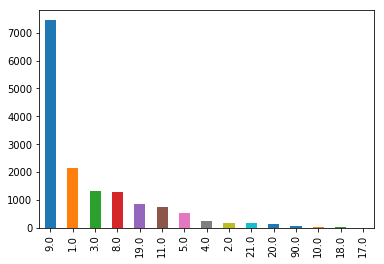

In [14]:
dataset['vehicle_type'].value_counts().head(15).plot.bar()

Percentage Bar Chart Visualization

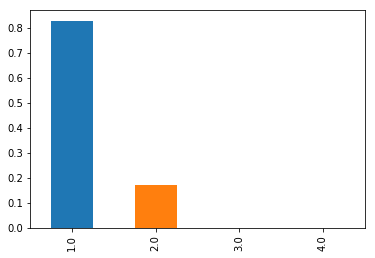

In [15]:
(dataset['road_surface_conditions'].value_counts()/len(dataset)).plot.bar()

In [16]:
(dataset['DAY_OF_WEEK'].value_counts()/len(dataset).plot.bar()

SyntaxError: unexpected EOF while parsing (<ipython-input-16-11e8d457e495>, line 1)

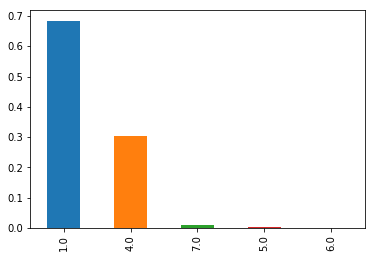

In [17]:
(dataset['light_conditions'].value_counts()/len(dataset)).plot.bar()

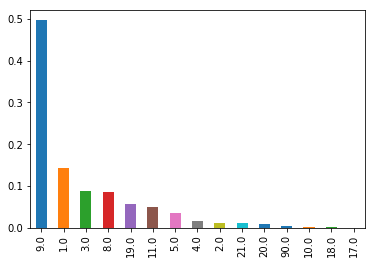

In [18]:
(dataset['vehicle_type'].value_counts()/len(dataset)).plot.bar()

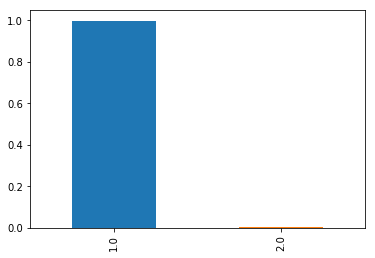

In [19]:
(dataset['was_vehicle_left_hand_drive?'].value_counts().head(15)/len(dataset)).plot.bar()

Line Chart Visualization

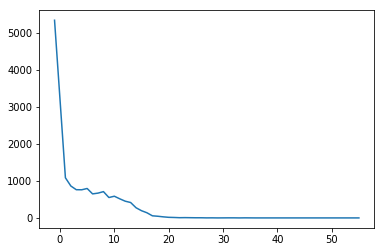

In [20]:
dataset['age_of_vehicle'].value_counts().sort_index().plot.line()

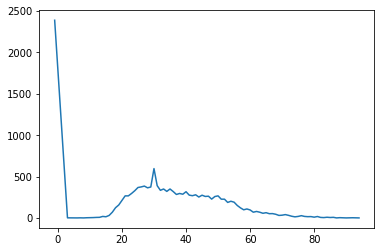

In [21]:
dataset['age_of_driver'].value_counts().sort_index().plot.line()

Verify the Data Quality

In [22]:
dataset.isnull().sum()

accident_index                                         1
vehicle_reference                                      1
vehicle_type                                           1
towing_and_articulation                                1
vehicle_manoeuvre                                      1
vehicle_location-restricted_lane                       1
junction_location                                      1
skidding_and_overturning                               1
hit_object_in_carriageway                              1
vehicle_leaving_carriageway                            1
hit_object_off_carriageway                             1
1st_point_of_impact                                    1
was_vehicle_left_hand_drive?                           1
journey_purpose_of_driver                              1
sex_of_driver                                          1
age_of_driver                                          3
age_band_of_driver                                     1
engine_capacity_(cc)           

In [23]:
dupRows = dataset.duplicated().sum()
print(dupRows)

0


Clean the Data

Clean the Rows Include Missing Values

In [24]:
dataset.dropna(axis=0, how='any', inplace=True)

In [25]:
print (dataset.isnull().sum())

accident_index                                      0
vehicle_reference                                   0
vehicle_type                                        0
towing_and_articulation                             0
vehicle_manoeuvre                                   0
vehicle_location-restricted_lane                    0
junction_location                                   0
skidding_and_overturning                            0
hit_object_in_carriageway                           0
vehicle_leaving_carriageway                         0
hit_object_off_carriageway                          0
1st_point_of_impact                                 0
was_vehicle_left_hand_drive?                        0
journey_purpose_of_driver                           0
sex_of_driver                                       0
age_of_driver                                       0
age_band_of_driver                                  0
engine_capacity_(cc)                                0
propulsion_code             

Reduce Data

In [26]:

dataset.drop(['casualty_home_area_type'],axis=1,inplace=True)
dataset.drop(['casualty_imd_decile'],axis=1,inplace=True)
dataset.drop(['bus_or_coach_passenger'],axis=1,inplace=True)
dataset.drop(['special_conditions_at_site'],axis=1,inplace=True)
dataset.drop(['carriageway_hazards'],axis=1,inplace=True)
dataset.drop(['junction_control'],axis=1,inplace=True)
dataset.head(n=5)

,accident_index,vehicle_reference,vehicle_type,towing_and_articulation,vehicle_manoeuvre,vehicle_location-restricted_lane,junction_location,skidding_and_overturning,hit_object_in_carriageway,vehicle_leaving_carriageway,...,casualty_class,sex_of_casualty,age_of_casualty,age_band_of_casualty,casualty_severity,pedestrian_location,pedestrian_movement,car_passenger,pedestrian_road_maintenance_worker,casualty_type
2,201506E098766,2.0,9.0,0.0,18.0,0.0,8.0,0.0,0.0,0.0,...,1.0,1.0,51.0,8.0,3.0,0.0,0.0,0.0,0.0,9.0
3,201506E098777,1.0,20.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,3.0,2.0,34.0,6.0,3.0,1.0,1.0,0.0,0.0,0.0
5,201506E098780,2.0,1.0,0.0,9.0,0.0,5.0,0.0,0.0,0.0,...,1.0,1.0,46.0,8.0,3.0,0.0,0.0,0.0,0.0,1.0
6,201506E098792,1.0,3.0,0.0,4.0,0.0,2.0,0.0,0.0,0.0,...,1.0,2.0,27.0,6.0,3.0,0.0,0.0,0.0,0.0,3.0
8,201506E098804,1.0,9.0,0.0,14.0,0.0,1.0,0.0,0.0,0.0,...,3.0,1.0,12.0,3.0,3.0,1.0,2.0,0.0,0.0,0.0
